In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cài đặt các thư viện cần thiết

In [3]:
pip install pyvi

     |████████████████████████████████| 8.5MB 4.6MB/s 
     |████████████████████████████████| 747kB 39.7MB/s 


In [4]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.5MB/s 


#Import thư viện 

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import re
import sys
from pyvi import ViTokenizer
from sklearn.metrics import classification_report,f1_score
from sklearn.pipeline import Pipeline

import kerastuner as kt
import IPython


# Tiền xử lý dữ liệu

In [6]:
df = pd.read_csv('/content/drive/MyDrive/DAUD1_project/dataFull.csv')

In [7]:
df['sentiment'].value_counts()

positive    6600
negative    2681
neutral      942
Name: sentiment, dtype: int64

In [8]:
positive = df[df['sentiment']=='positive']
negative = df[df['sentiment']=='negative']
neutral = df[df['sentiment']=='neutral']

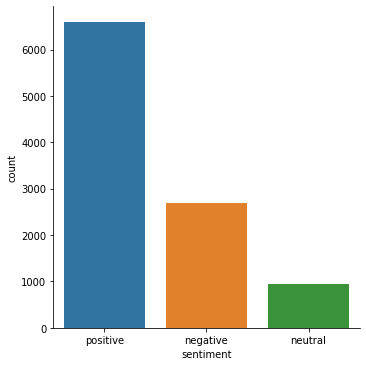

In [9]:
import seaborn as sns
sns.catplot(x="sentiment",kind="count",data=df)

In [10]:
data = pd.DataFrame()
data = data.append(negative.sample(900))
data = data.append(positive.sample(900))
data = data.append(neutral.sample(900))

In [11]:
data = df

In [12]:
text = data['review']
len(text)

10223

In [13]:
text = text.reset_index()['review']

##Làm sạch văn bản 

In [14]:
# https://stackoverflow.com/a/49146722/330558
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [15]:
def sentence_segment(string):
    return string.lower()

In [16]:
def standardize_data(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Xóa tất cả dấu trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ") \
        .replace("("," ").replace(")"," ") \
        .replace("%"," ").replace("+"," ") \
        .replace("="," ")
    row = row.strip()
    return row

In [17]:
clean_text = text.apply(remove_emoji)
clean_text = clean_text.apply(sentence_segment)
clean_text = clean_text.apply(standardize_data)

##Độ dài trung bình của các câu

In [18]:
length = []
for i in range(len(clean_text)):
  length+=[len(clean_text[i].split())]

In [19]:
pd.DataFrame(length).describe().astype('int')

,0
count,10223
mean,13
std,10
min,1
25%,7
50%,10
75%,16
max,141


## Tách từ

In [20]:
corpus = []
for reviews in clean_text:
    reviews = ViTokenizer.tokenize(reviews)
    corpus.append(reviews)

In [21]:
separator = ' '
corpus_join = separator.join(corpus)

## Top 10 từ xuất hiện nhiều nhất

In [22]:
from collections import Counter
split_it = corpus_join.split() 
  
# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_it) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(10) 
  
print(most_occur)

[('ảnh', 3832), ('rất', 3132), ('tốt', 1678), ('ứng_dụng', 1660), ('lưu', 1549), ('tôi', 1480), ('không', 1431), ('được', 1431), ('sao', 1411), ('và', 1317)]


##Chia tập dữ liệu

In [23]:
Y = data['sentiment']
X_train, X_test, Y_train, Y_test = train_test_split(corpus, Y, train_size= 0.8, random_state=0)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, train_size= 0.5, random_state=0)

In [24]:
Y_train.value_counts()

positive    5320
negative    2118
neutral      740
Name: sentiment, dtype: int64

In [25]:
Y_val.value_counts()

positive    633
negative    285
neutral     105
Name: sentiment, dtype: int64

In [26]:
Y_test.value_counts()

positive    647
negative    278
neutral      97
Name: sentiment, dtype: int64

# Huấn luyện mô hình

##Naive Bayes

In [27]:
pipe = Pipeline([('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])
pipe.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('nb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:
print('Train set\n',classification_report(Y_train,pipe.predict(X_train)))

Train set
               precision    recall  f1-score   support

    negative       0.83      0.90      0.86      2118
     neutral       0.74      0.51      0.61       740
    positive       0.94      0.95      0.94      5320

    accuracy                           0.89      8178
   macro avg       0.84      0.79      0.80      8178
weighted avg       0.89      0.89      0.89      8178



In [29]:
print('Test set\n',classification_report(Y_test,pipe.predict(X_test)))

Test set
               precision    recall  f1-score   support

    negative       0.79      0.87      0.83       278
     neutral       0.65      0.35      0.46        97
    positive       0.91      0.94      0.92       647

    accuracy                           0.86      1022
   macro avg       0.79      0.72      0.74      1022
weighted avg       0.85      0.86      0.85      1022



In [30]:
import joblib
joblib.dump(pipe,'/content/drive/MyDrive/DAUD1_project/naive_bayes.h5')

['/content/drive/MyDrive/DAUD1_project/naive_bayes.h5']

##Transformer

###Word Embedding

In [32]:
dim = 32

In [33]:
train_data = []
for sents in X_train:
  train_data.append(sents.split())
from gensim.models import FastText
model_fasttext = FastText(size=dim, window=10, min_count=2, workers=4, sg=1)
model_fasttext.build_vocab(train_data)
model_fasttext.train(train_data, total_examples=model_fasttext.corpus_count, epochs=model_fasttext.iter)
vocab = model_fasttext.wv.vocab
embedding_matrix = model_fasttext.wv.vectors

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys


### Tạo các class cần thiết

In [34]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [35]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [36]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim,embedding_matrix):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,weights = [embedding_matrix])
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### Encoder dữ liệu

In [37]:
x_train = [sent.split() for sent in X_train]
x_test = [sent.split() for sent in X_test]
x_val = [sent.split() for sent in X_val]

In [38]:
maxlen = 140
vocab_size = len(vocab)
max_words = vocab_size

In [39]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
X_train_sq = tokenizer.texts_to_sequences(x_train)
X_train_sq = pad_sequences(X_train_sq,maxlen = maxlen)
X_test_sq = tokenizer.texts_to_sequences(x_test)
X_test_sq = pad_sequences(X_test_sq,maxlen=maxlen)
X_val_sq = tokenizer.texts_to_sequences(x_val)
X_val_sq = pad_sequences(X_val_sq,maxlen=maxlen)

###Huấn luyện

In [40]:
embed_dim = dim  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = dim  # Hidden layer size in feed forward network inside transformer
def model_builder(hp):
  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim,embedding_matrix)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  hp_units = hp.Int('units', min_value = 10, max_value = 100, step = 10)
  x = layers.Dense(units = hp_units, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(3, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss= "categorical_crossentropy",metrics=["accuracy"])
  return model 
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_direct',
                     project_name = 'intro_to_kt_2')

In [41]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [42]:
y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(Y_test)
y_val = pd.get_dummies(Y_val)

In [43]:
tuner.search(X_train_sq, y_train,batch_size=16, epochs = 10, validation_data = (X_val_sq, y_val), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 00m 48s]
val_accuracy: 0.8289344906806946

Best val_accuracy So Far: 0.8778103590011597
Total elapsed time: 00h 10m 45s
INFO:tensorflow:Oracle triggered exit


In [44]:
best_hps.values

{'learning_rate': 0.001,
 'tuner/bracket': 2,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 2,
 'tuner/round': 1,
 'tuner/trial_id': 'c072f3de490908818405a44d7733c958',
 'units': 70}

In [45]:
model = tuner.hypermodel.build(best_hps)

In [46]:
model.fit(X_train_sq, y_train,batch_size=16, epochs = 4, validation_data = (X_val_sq, y_val))

Epoch 1/4
512/512 [==============================] - 7s 10ms/step - loss: 0.7658 - accuracy: 0.6884 - val_loss: 0.4996 - val_accuracy: 0.8182
Epoch 2/4
512/512 [==============================] - 4s 9ms/step - loss: 0.3904 - accuracy: 0.8540 - val_loss: 0.3883 - val_accuracy: 0.8622
Epoch 3/4
512/512 [==============================] - 4s 9ms/step - loss: 0.2698 - accuracy: 0.8997 - val_loss: 0.4490 - val_accuracy: 0.8407
Epoch 4/4
512/512 [==============================] - 4s 9ms/step - loss: 0.2306 - accuracy: 0.9125 - val_loss: 0.4322 - val_accuracy: 0.8592


In [47]:
y_pre_test = model.predict(X_test_sq)
y_pre_train = model.predict(X_train_sq)

In [48]:
print(classification_report(np.array(y_train.values).argmax(axis = 1),y_pre_train.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2118
           1       0.78      0.65      0.71       740
           2       0.97      0.96      0.97      5320

    accuracy                           0.93      8178
   macro avg       0.88      0.86      0.87      8178
weighted avg       0.93      0.93      0.93      8178



In [49]:
print(classification_report(np.array(y_test.values).argmax(axis = 1),y_pre_test.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       278
           1       0.69      0.48      0.57        97
           2       0.94      0.92      0.93       647

    accuracy                           0.88      1022
   macro avg       0.81      0.77      0.78      1022
weighted avg       0.88      0.88      0.87      1022



In [50]:
model.save('/content/drive/MyDrive/DAUD1_project/Transformer')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DAUD1_project/Transformer/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DAUD1_project/Transformer/assets
